<a href="https://colab.research.google.com/github/navneetkrc/langchain_colab_experiments/blob/main/working_with_receipts_image_data_with_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q llama-index pip install gpt-index transformers sentencepiece

In [ ]:
!pip install -q xlrd
!git clone https://github.com/jerryjliu/llama_index.git

In [3]:
import os
os.environ['OPENAI_API_KEY'] ="your_own_token"


In [4]:
from gpt_index import SimpleDirectoryReader, GPTSimpleVectorIndex
from gpt_index.readers.file.base import (
    DEFAULT_FILE_EXTRACTOR, 
    ImageParser,
)
from gpt_index.response.notebook_utils import (
    display_response, 
    display_image,
)
from gpt_index.indices.query.query_transform.base import (
    ImageOutputQueryTransform,
)

In [5]:
# NOTE: By default, image parser converts image into text and discard the original image.  
#       Here, we explicitly keep both the original image and parsed text in an image document
image_parser = ImageParser(keep_image=True, parse_text=True)
file_extractor = DEFAULT_FILE_EXTRACTOR
file_extractor.update(
{
    ".jpg": image_parser,
    ".png": image_parser,
    ".jpeg": image_parser,
})

# NOTE: we add filename as metadata for all documents
filename_fn = lambda filename: {'file_name': filename}

# Q&A over Receipt Images

We first ingest our receipt images with the *custom* `image parser` and `metadata function` defined above.   
This gives us `image documents` instead of only text documents.

In [ ]:
receipt_reader = SimpleDirectoryReader(
    input_dir='/content/llama_index/examples/multimodal/data/receipts', 
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
receipt_documents = receipt_reader.load_data()

We build a simple vector index as usual, but unlike before, our index holds images in addition to text.

In [7]:
receipts_index = GPTSimpleVectorIndex.from_documents(receipt_documents)

We can now ask a question that prompts for response with both text and image.  
We use a custom query transform `ImageOutputQueryTransform` to add instruction on how to display the image nicely in the notebook.

In [8]:
receipts_response = receipts_index.query(
    'When was the last time I went to McDonald\'s and how much did I spend. \
    Also show me the receipt from my visit.',
    query_transform=ImageOutputQueryTransform(width=400)
)

We now have rich multimodal response with inline text and image!  

The source nodes section gives additional details on retrieved data used for synthesizing the final response.  
In this case, we can verify that the receipt for McDonald's is correctly retrieved. 

**`Final Response:`** The last time you went to McDonald's was on 03/10/2018 at 07:39:12 PM and you spent $26.15. Here is the receipt from your visit: <img src="/content/llama_index/examples/multimodal/data/receipts/1100-receipt.jpg" width="400" />

---

**`Source Node 1/1`**

**Document ID:** 95a85533-518c-4162-bee4-ce2eea699bd6<br>**Similarity:** 0.787393497648776<br>**Text:** file_name: /content/llama_index/examples/multimodal/data/receipts/1100-receipt.jpg

<s_menu><s_nm...<br>**Image:**

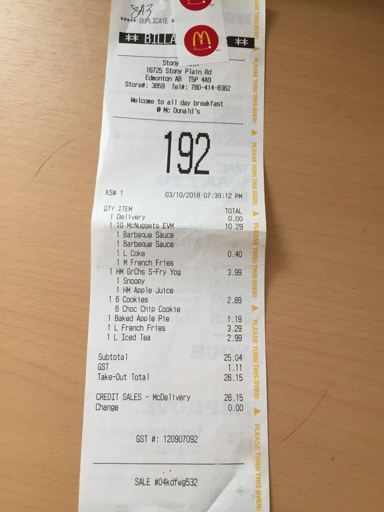

In [9]:
display_response(receipts_response)

# Q & A over LlamaIndex Documentation

We now demo the same for Q&A over LlamaIndex documentations.   
This demo higlights the ability to synthesize multimodal output with a mixture of text and image documents

In [10]:
llama_reader = SimpleDirectoryReader(
    input_dir='/content/llama_index/examples/multimodal/data/llama',
    file_extractor=file_extractor, 
    file_metadata=filename_fn,
)
llama_documents = llama_reader.load_data(concatenate=True)

In [11]:
llama_index = GPTSimpleVectorIndex.from_documents(llama_documents)

In [12]:
llama_documents

[Document(text='\n\nHow Each Index Works\n\nThis guide describes how each index works with diagrams. We also visually highlight our "Response Synthesis" modes.\n\nSome terminology:\n- **Node**: Corresponds to a chunk of text from a Document. LlamaIndex takes in Document objects and internally parses/chunks them into Node objects.\n- **Response Synthesis**: Our module which synthesizes a response given the retrieved Node. You can see how to \n    specify different response modes here. \n    See below for an illustration of how each response mode works.\n\n\n\n\nList Index\n\nThe list index simply stores Nodes as a sequential chain.\n\n!\n\n\n\n\nQuerying\n\nDuring query time, if no other query parameters are specified, LlamaIndex simply loads all Nodes in the list into\nour Reponse Synthesis module.\n\n!\n\nThe list index does offer numerous ways of querying a list index, from an embedding-based query which \nwill fetch the top-k neighbors, or with the addition of a keyword filter, as s

In [13]:
llama_response = llama_index.query(
    'Show an image to illustrate how tree index works and explain briefly.', 
    query_transform=ImageOutputQueryTransform(width=400),
    similarity_top_k=2
)

By inspecting the 2 source nodes, we see relevant text and image describing the tree index are retrieved for synthesizing the final multimodal response.

**`Final Response:`** <img src="/content/llama_index/examples/multimodal/data/llama/tree_index.png" width="400" />
Tree indexing is a way of organizing data in a hierarchical structure. It is a type of indexing that uses a tree-like structure to store data. Each node in the tree contains a key and a value, and each node can have multiple children. The root node is the topmost node in the tree, and each node below it is a child of the root node. The tree structure allows for efficient retrieval of data, as it allows for quick traversal of the tree to find the desired data. During query time, if no other query parameters are specified, LlamaIndex simply loads all Nodes in the tree into our Reponse Synthesis module. Querying a tree index involves traversing from root nodes down to leaf nodes. By default, (`child_branch_factor=1`), a query chooses one child node given a parent node. If `child_branch_factor=2`, a query chooses two child nodes per parent. LlamaIndex offers different methods of synthesizing a response. The way to toggle this can be found in

---

**`Source Node 1/2`**

**Document ID:** 05709ad3-028b-4ce6-9060-e7bb8e5360a7<br>**Similarity:** 0.8234305141867426<br>**Text:** file_name: /content/llama_index/examples/multimodal/data/llama/tree_index.png

<s_menu><s_nm> Roo...<br>**Image:**

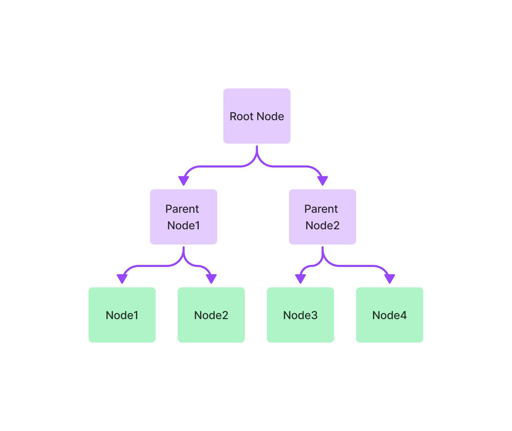

---

**`Source Node 2/2`**

**Document ID:** 74bb94f8-1ad8-4024-b8fb-28a85db038b8<br>**Similarity:** 0.8139007549751248<br>**Text:** How Each Index Works

This guide describes how each index works with diagrams. We also visually h...<br>

In [14]:
display_response(llama_response)

We show another example asking about vector store index instead.

In [15]:
llama_response = llama_index.query(
    'Show an image to illustrate how vector store index works and explain briefly.', 
    query_transform=ImageOutputQueryTransform(width=400),
    similarity_top_k=2
)

**`Final Response:`** <img src="/content/llama_index/examples/multimodal/data/llama/vector_store_index.png" width="400" />
Vector store index is a data structure used to store and retrieve data efficiently. It uses a vector of keys to store data in a sorted order, allowing for fast retrieval of data. The vector store index is a powerful tool for data storage and retrieval, as it allows for quick access to data without having to search through a large data set. During query time, the vector store index fetches the top-k most similar Nodes, and passes those into our Response Synthesis module. LlamaIndex offers different methods of synthesizing a response, such as Create and Refine and Tree Summarize. Create and Refine is an iterative way of generating a response, while Tree Summarize builds a tree index over the set of candidate nodes with a summary prompt seeded with the query.

---

**`Source Node 1/2`**

**Document ID:** 1045b69c-96e1-4aed-8815-5061965babbe<br>**Similarity:** 0.8188326376030887<br>**Text:** file_name: /content/llama_index/examples/multimodal/data/llama/vector_store_index.png

<s_menu><s...<br>**Image:**

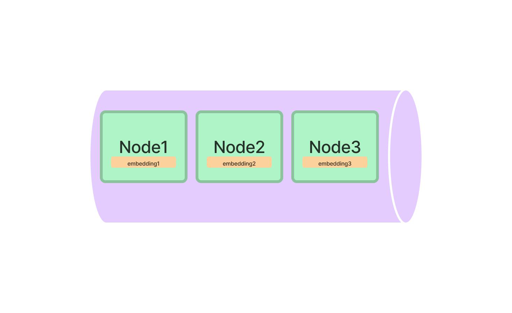

---

**`Source Node 2/2`**

**Document ID:** 74bb94f8-1ad8-4024-b8fb-28a85db038b8<br>**Similarity:** 0.7878806797032482<br>**Text:** How Each Index Works

This guide describes how each index works with diagrams. We also visually h...<br>

In [16]:
display_response(llama_response)